In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


<h3>Load datasets</h3>

In [3]:
# Base path
base_path = r"C:\Users\ansh1\OneDrive\Desktop\UA\\"

# Load datasets
airports = pd.read_csv(base_path + "Airports Data.csv")
bags = pd.read_csv(base_path + "Bag Level Data.csv")
flights = pd.read_csv(base_path + "Flight Level Data.csv")
pnr_flight = pd.read_csv(base_path + "PNR Flight Level Data.csv")
pnr_remark = pd.read_csv(base_path + "PNR Remark Level Data.csv")



<h3>Process flight delays</h3>

In [4]:
# Convert datetime columns
flights['sched_dep'] = pd.to_datetime(flights['scheduled_departure_datetime_local'])
flights['actual_dep'] = pd.to_datetime(flights['actual_departure_datetime_local'])

# Delay in minutes
flights['delay_min'] = (flights['actual_dep'] - flights['sched_dep']).dt.total_seconds() / 60

# Basic metrics
avg_delay = flights['delay_min'].mean()
pct_delayed = (flights['delay_min'] > 0).mean() * 100

print(f"Average delay: {avg_delay:.2f} min, Flights delayed: {pct_delayed:.2f}%")


Average delay: 21.18 min, Flights delayed: 49.61%


<h3>Total passengers per flight</h3>

In [5]:
pax = (
    pnr_flight.groupby(['flight_number', 'scheduled_departure_date_local'])['total_pax']
    .sum().reset_index().rename(columns={'total_pax': 'passengers'})
)

df = flights.merge(pax, on=['flight_number', 'scheduled_departure_date_local'], how='left')


<h3>Bag counts and transfer ratio</h3>

In [6]:
bag_counts = bags.groupby(['flight_number', 'scheduled_departure_date_local', 'bag_type']).size().unstack(fill_value=0)
bag_counts['transfer_ratio'] = bag_counts.get('Transfer', 0) / bag_counts.get('Checked', 1)
bag_counts = bag_counts.reset_index()

df = df.merge(bag_counts, on=['flight_number','scheduled_departure_date_local'], how='left')


<h3>SSR counts</h3>

In [7]:
ssr = pnr_remark.groupby(['flight_number', 'pnr_creation_date']).size().reset_index(name='ssr_count')
df = df.merge(ssr, left_on=['flight_number','scheduled_departure_date_local'], right_on=['flight_number','pnr_creation_date'], how='left')
df.drop(columns=['pnr_creation_date'], inplace=True)


<h3>Create flags</h3>

In [8]:
# Tight ground time flag
df['tight_ground'] = df['scheduled_ground_time_minutes'] <= df['minimum_turn_minutes']

# High passenger load flag (90th percentile)
pax_90 = df['passengers'].quantile(0.9)
df['high_load'] = df['passengers'] > pax_90

# Fill missing SSRs and bag ratios
df['ssr_count'] = df['ssr_count'].fillna(0)
df['transfer_ratio'] = df['transfer_ratio'].fillna(0)


<h3>Normalize numeric features</h3>

In [9]:
scaler = MinMaxScaler()
df[['delay_norm','ssr_norm','bag_ratio_norm','load_norm']] = scaler.fit_transform(
    df[['delay_min','ssr_count','transfer_ratio','passengers']]
)

# Encode boolean flags
df['tight_flag'] = df['tight_ground'].astype(int)
df['high_load_flag'] = df['high_load'].astype(int)


<h3>Compute Flight Difficulty Score</h3>

In [10]:
df['difficulty_score'] = (
    0.3*df['delay_norm'] + 
    0.2*df['ssr_norm'] + 
    0.2*df['bag_ratio_norm'] + 
    0.2*df['load_norm'] + 
    0.1*df['tight_flag']
)

# Rank within each day
df['daily_rank'] = df.groupby('scheduled_departure_date_local')['difficulty_score'].rank(method='first', ascending=False)

# Classify top 20% Difficult, bottom 20% Easy, rest Medium
df['difficulty_cat'] = df.groupby('scheduled_departure_date_local')['daily_rank'] \
                         .transform(lambda x: x.rank(pct=True)) \
                         .apply(lambda x: 'Difficult' if x <= 0.2 else ('Easy' if x > 0.8 else 'Medium'))


<h3>visualize</h3>

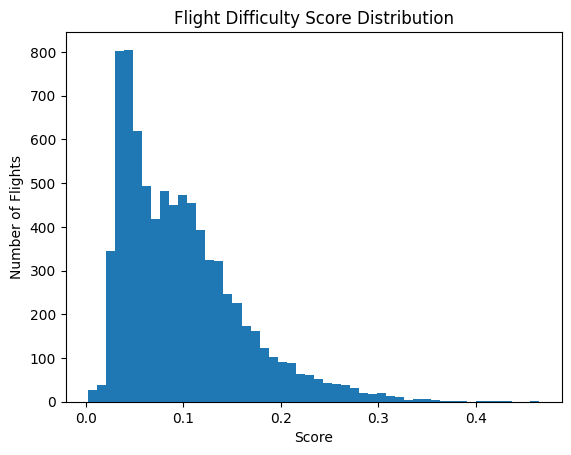

,company_id,flight_number,scheduled_departure_date_local,scheduled_departure_station_code,scheduled_arrival_station_code,scheduled_departure_datetime_local,scheduled_arrival_datetime_local,actual_departure_datetime_local,actual_arrival_datetime_local,total_seats,...,high_load,delay_norm,ssr_norm,bag_ratio_norm,load_norm,tight_flag,high_load_flag,difficulty_score,daily_rank,difficulty_cat
6984,UA,972,2025-08-01,ORD,BRU,2025-08-01T17:50:00Z,2025-08-02T08:50:00Z,2025-08-01T20:23:00Z,2025-08-02T10:50:00Z,318,...,True,0.164410,0.111111,0.788571,0.671727,0,1,0.363605,1.0,Difficult
6578,UA,1811,2025-08-01,ORD,MSP,2025-08-01T12:45:00Z,2025-08-01T14:28:00Z,2025-08-01T13:39:00Z,2025-08-01T15:01:00Z,166,...,False,0.068665,0.333333,0.334286,0.375712,1,0,0.329266,2.0,Difficult
1842,UA,1363,2025-08-01,ORD,LAX,2025-08-01T12:54:00Z,2025-08-01T15:23:00Z,2025-08-01T13:16:00Z,2025-08-01T15:51:00Z,200,...,True,0.037718,0.555556,0.080000,0.451613,1,1,0.328749,3.0,Difficult
2925,UA,2182,2025-08-01,ORD,PHL,2025-08-01T11:20:00Z,2025-08-01T14:29:00Z,2025-08-01T11:42:00Z,2025-08-01T14:36:00Z,150,...,False,0.037718,0.666667,0.065714,0.351044,1,0,0.328000,4.0,Difficult
1680,UA,2207,2025-08-01,ORD,OMA,2025-08-01T15:58:00Z,2025-08-01T17:36:00Z,2025-08-01T16:27:00Z,2025-08-01T17:48:00Z,179,...,False,0.044487,0.333333,0.271429,0.387097,1,0,0.311718,5.0,Difficult
235,UA,845,2025-08-01,ORD,GRU,2025-08-01T21:20:00Z,2025-08-02T09:30:00Z,2025-08-01T21:36:00Z,2025-08-02T09:32:00Z,318,...,True,0.031915,0.222222,0.574286,0.690702,0,1,0.307016,6.0,Difficult
1830,UA,219,2025-08-01,ORD,HNL,2025-08-01T09:30:00Z,2025-08-01T13:30:00Z,2025-08-01T09:50:00Z,2025-08-01T13:42:00Z,318,...,True,0.035783,0.333333,0.337143,0.808349,0,1,0.306500,7.0,Difficult
7943,UA,881,2025-08-01,ORD,HND,2025-08-01T12:50:00Z,2025-08-02T15:55:00Z,2025-08-01T13:00:00Z,2025-08-02T15:47:00Z,318,...,True,0.026112,0.000000,0.748571,0.741935,0,1,0.305935,8.0,Difficult
7701,UA,944,2025-08-01,ORD,FRA,2025-08-01T15:10:00Z,2025-08-02T06:30:00Z,2025-08-01T16:40:00Z,2025-08-02T08:01:00Z,318,...,True,0.103482,0.000000,0.585714,0.751423,0,1,0.298472,9.0,Difficult
4010,UA,1584,2025-08-01,ORD,LAX,2025-08-01T10:50:00Z,2025-08-01T13:23:00Z,2025-08-01T12:06:00Z,2025-08-01T14:22:00Z,200,...,True,0.089942,0.222222,0.117143,0.485769,1,1,0.292009,10.0,Difficult


In [11]:
# Histogram of scores
plt.hist(df['difficulty_score'], bins=50)
plt.title("Flight Difficulty Score Distribution")
plt.xlabel("Score")
plt.ylabel("Number of Flights")
plt.show()

# Top difficult flights
top_difficult = df[df['difficulty_cat']=='Difficult'].sort_values(['scheduled_departure_date_local','difficulty_score'], ascending=[True,False])
top_difficult.head(10)


In [12]:
df.to_csv(base_path + "anshul.csv", index=False)
